In [180]:
import datetime
import math

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib as plt
import scipy

In [2]:
tsla = pd.read_csv('TSLA_raw_1d_2010-06-29_2022-04-22.csv', index_col=0, parse_dates=True)
index = pd.read_csv('SNP_raw_1d_2000-10-18_2022-04-22.csv', index_col=0, parse_dates=True)
beta = pd.read_csv('TSLA_beta_2012-03-31_2022-03-31.csv', index_col=0, parse_dates=True)

Run the cell with the dataset you want to analyze

In [3]:
twitter = pd.read_csv('all_tweets_analyzed.csv', index_col=0, parse_dates=True)

In [4]:
twitter = pd.read_csv('all_elon_tweets_analyzed.csv', index_col=0, parse_dates=True)

In [ ]:
twitter = pd.read_csv('from_tesla_tweets_analyzed.csv', index_col=0, parse_dates=True)

In [ ]:
twitter = pd.read_csv('written_by_elon_analyzed.csv', index_col=0, parse_dates=True)

In [5]:
twitter

,signed_sentiment,continuous_sentiment,like_count,quote_count,reply_count,retweet_count,user_verified,user_followersCount,user_friendsCount,user_statusesCount,user_favouritesCount,user_listedCount,user_mediaCount
created_at,,,,,,,,,,,,,
2016-01-01 14:55:00+00:00,0.998769,0.997537,259,0,7,124,True,57845224,1104,372125,1398,154215,176990
2016-01-01 12:14:54+00:00,0.998993,0.997987,137,0,4,162,True,2411104,266,199380,1747,49097,86356
2016-01-01 17:40:35+00:00,0.998403,0.996805,9,0,1,6,False,3823,2201,4776,1475,126,965
2016-01-01 19:00:58+00:00,-0.941671,-0.883343,28,0,0,29,True,3679772,414,708692,2121,35298,334579
2016-01-01 16:33:07+00:00,0.999856,0.999711,6,0,2,9,True,334134,1357,139794,533,5856,73601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-15 23:33:53+00:00,0.812037,0.624074,0,0,0,0,False,10482,10425,86599,21699,70,59141
2022-04-15 23:30:29+00:00,0.976741,0.953482,0,0,0,0,False,1818,4456,32284,18655,3,2978
2022-04-15 23:42:25+00:00,0.969052,0.938104,0,0,0,0,False,144,140,29793,35563,11,695


In [6]:
def try_weighted_average(primary, weight):
    try:
        return np.average(primary, weights=weight)
    except ZeroDivisionError:
        return np.average(primary)


def create_1d_weighted_features(primaries, weights):
    dataframe = {}
    for primary in primaries:
        dataframe[f"average_{primary}"] = twitter.groupby([twitter.index.date]).apply(lambda x: np.average(x[primary]))
        for weight in weights:
            dataframe[f"average_{primary}_weighted_by_{weight}"] = twitter.groupby([twitter.index.date]).apply(lambda x: try_weighted_average(x[primary], x[weight]))
    return dataframe

user_weighted_features = create_1d_weighted_features(['signed_sentiment', 'continuous_sentiment'], ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'user_verified', 'user_followersCount', 'user_friendsCount', 'user_statusesCount', 'user_favouritesCount', 'user_listedCount', 'user_mediaCount'])
tweet_weighted_features = create_1d_weighted_features(['signed_sentiment', 'continuous_sentiment'], ['like_count', 'quote_count', 'reply_count', 'retweet_count'])

In [7]:
def create_feature_sums(secondaries):
    dataframe = {}
    for secondary in secondaries:
        dataframe[secondary] = twitter.groupby([twitter.index.date])[secondary].sum()
    return dataframe

feature_sums = create_feature_sums(['like_count', 'quote_count', 'reply_count', 'retweet_count'])
feature_sums['tweet_count'] = twitter.groupby([twitter.index.date]).size()

In [8]:
new_twitter = pd.DataFrame({**user_weighted_features, **feature_sums})
new_twitter

,average_signed_sentiment,average_signed_sentiment_weighted_by_like_count,average_signed_sentiment_weighted_by_quote_count,average_signed_sentiment_weighted_by_reply_count,average_signed_sentiment_weighted_by_retweet_count,average_signed_sentiment_weighted_by_user_verified,average_signed_sentiment_weighted_by_user_followersCount,average_signed_sentiment_weighted_by_user_friendsCount,average_signed_sentiment_weighted_by_user_statusesCount,average_signed_sentiment_weighted_by_user_favouritesCount,...,average_continuous_sentiment_weighted_by_user_friendsCount,average_continuous_sentiment_weighted_by_user_statusesCount,average_continuous_sentiment_weighted_by_user_favouritesCount,average_continuous_sentiment_weighted_by_user_listedCount,average_continuous_sentiment_weighted_by_user_mediaCount,like_count,quote_count,reply_count,retweet_count,tweet_count
2016-01-01,0.359931,0.678010,0.359931,0.764845,0.640442,0.576020,0.889725,0.589556,0.160931,-0.089058,...,0.604439,0.187500,-0.030801,0.759762,0.480421,1091,0,51,751,83
2016-01-04,0.345329,0.182500,0.345329,-0.145844,-0.034994,0.345725,0.751333,0.575512,0.374260,0.258153,...,0.579210,0.371406,0.218214,0.637065,0.336459,584,0,48,570,95
2016-01-05,0.227878,0.422636,0.227878,-0.653870,-0.026754,0.175598,0.740246,0.538825,0.064441,0.275396,...,0.521232,0.076258,0.290722,0.379641,0.339508,480,0,42,265,95
2016-01-06,0.494676,0.693134,-0.819803,0.439810,0.608620,0.551025,0.458962,0.165045,0.356960,0.268568,...,0.169323,0.358330,0.271775,0.517395,0.314164,293,2,34,142,98
2016-01-07,0.273403,0.176104,0.273403,0.080853,-0.271440,-0.166740,0.218940,-0.291837,0.251336,-0.516717,...,-0.234897,0.175659,-0.455890,-0.192893,0.256622,440,0,40,300,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,-0.374293,0.090487,-0.579625,-0.455999,-0.151154,-0.668094,-0.864543,0.012013,-0.569881,-0.219462,...,-0.030652,-0.514272,-0.197827,-0.752337,-0.733173,51496,780,3913,6425,86
2022-04-12,-0.596560,0.131902,-0.403283,-0.016704,-0.313645,-0.787262,-0.972325,-0.872326,-0.872810,-0.693882,...,-0.872199,-0.860214,-0.709670,-0.947372,-0.927423,47762,624,2088,8073,90
2022-04-13,-0.422210,0.286575,-0.067436,0.024903,-0.109668,-0.460228,-0.678260,-0.591966,-0.514979,-0.130346,...,-0.566050,-0.478206,-0.147450,-0.457430,-0.660143,24918,253,1497,2715,93
2022-04-14,-0.496539,-0.833363,-0.932976,-0.847880,-0.909650,-0.786533,-0.875431,-0.610371,-0.757930,-0.560375,...,-0.609271,-0.754263,-0.562004,-0.831014,-0.883371,148176,1130,3499,25917,91


In [9]:
tsla

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,93831500,0,0.0
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500,0,0.0
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000,0,0.0
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000,0,0.0
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500,0,0.0
...,...,...,...,...,...,...,...
2022-04-18,989.030029,1014.919983,973.409973,1004.289978,17238400,0,0.0
2022-04-19,1005.059998,1034.939941,995.330017,1028.150024,16615900,0,0.0
2022-04-20,1030.000000,1034.000000,975.250000,977.200012,23570400,0,0.0


In [10]:
beta

,beta
2012-03-31,0.1019
2012-04-30,0.1775
2012-05-31,0.3636
2012-06-30,0.3792
2012-07-31,0.3809
...,...
2021-11-30,2.0310
2021-12-31,1.9780
2022-01-31,2.0000
2022-02-28,2.0440


In [11]:
percentage_increase = (tsla['Close'] - tsla['Open'])/tsla['Open'] * 100
index_percentage_increase = (index['Close'] - index['Open'])/index['Open'] * 100

index_and_beta = pd.merge(index, beta.resample('1d').fillna(method='backfill'), how='left', left_index=True, right_index=True)
index_and_beta.loc[:, ['beta']] = index_and_beta.loc[:, ['beta']].fillna(method='ffill')
index_beta_increase = index_percentage_increase * index_and_beta['beta']
adjusted_percentage_increase = percentage_increase - index_beta_increase

adjusted_percentage_increase = adjusted_percentage_increase.dropna()

label_dataframe = {
    'prev_2_day_percentage_increase': percentage_increase.shift(2),
    'prev_2_day_adjusted_percentage_increase': adjusted_percentage_increase.shift(2),
    'prev_2_day_label_raw_increase': (percentage_increase > 0).astype(int).shift(2, fill_value=0),
    'prev_2_day_label_adjusted_increase': (adjusted_percentage_increase > 0).astype(int).shift(2, fill_value=0),
    'prev_day_percentage_increase': percentage_increase.shift(1),
    'prev_day_adjusted_percentage_increase': adjusted_percentage_increase.shift(1),
    'prev_day_label_raw_increase': (percentage_increase > 0).astype(int).shift(1, fill_value=0),
    'prev_day_label_adjusted_increase': (adjusted_percentage_increase > 0).astype(int).shift(1, fill_value=0),
    'percentage_increase': percentage_increase,
    'adjusted_percentage_increase': adjusted_percentage_increase,
    'label_raw_increase': (percentage_increase > 0).astype(int),
    'label_adjusted_increase': (adjusted_percentage_increase > 0).astype(int),
}

final_labels = pd.DataFrame(label_dataframe, index=adjusted_percentage_increase.index)
final_labels

,prev_2_day_percentage_increase,prev_2_day_adjusted_percentage_increase,prev_2_day_label_raw_increase,prev_2_day_label_adjusted_increase,prev_day_percentage_increase,prev_day_adjusted_percentage_increase,prev_day_label_raw_increase,prev_day_label_adjusted_increase,percentage_increase,adjusted_percentage_increase,label_raw_increase,label_adjusted_increase
Date,,,,,,,,,,,,
2012-04-02,-2.251898,NaN,0,0,-0.746272,NaN,0,0,-2.009109,-2.236694,0,0
2012-04-03,-0.746272,NaN,0,0,-2.009109,-2.236694,0,0,3.569483,3.572732,1,1
2012-04-04,-2.009109,-2.236694,0,0,3.569483,3.572732,1,1,-0.765522,-0.763873,0,0
2012-04-05,3.569483,3.572732,1,1,-0.765522,-0.763873,0,0,-1.766383,-1.840720,0,0
2012-04-09,-0.765522,-0.763873,0,0,-1.766383,-1.840720,0,0,-2.785925,-2.909410,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-18,4.208625,3.106972,1,1,-1.430013,-2.529074,0,0,1.542921,1.623969,1,1
2022-04-19,-1.430013,-2.529074,0,0,1.542921,1.623969,1,1,2.297378,3.762218,1,1
2022-04-20,1.542921,1.623969,1,1,2.297378,3.762218,1,1,-5.126212,-4.306304,0,0


In [12]:
merged = pd.merge(new_twitter, final_labels, left_index=True, right_index=True)
merged

,average_signed_sentiment,average_signed_sentiment_weighted_by_like_count,average_signed_sentiment_weighted_by_quote_count,average_signed_sentiment_weighted_by_reply_count,average_signed_sentiment_weighted_by_retweet_count,average_signed_sentiment_weighted_by_user_verified,average_signed_sentiment_weighted_by_user_followersCount,average_signed_sentiment_weighted_by_user_friendsCount,average_signed_sentiment_weighted_by_user_statusesCount,average_signed_sentiment_weighted_by_user_favouritesCount,...,prev_2_day_label_raw_increase,prev_2_day_label_adjusted_increase,prev_day_percentage_increase,prev_day_adjusted_percentage_increase,prev_day_label_raw_increase,prev_day_label_adjusted_increase,percentage_increase,adjusted_percentage_increase,label_raw_increase,label_adjusted_increase
2016-01-04,0.345329,0.182500,0.345329,-0.145844,-0.034994,0.345725,0.751333,0.575512,0.374260,0.258153,...,1,1,0.628903,0.287316,1,1,-3.168346,-3.147559,0,0
2016-01-05,0.227878,0.422636,0.227878,-0.653870,-0.026754,0.175598,0.740246,0.538825,0.064441,0.275396,...,1,1,-3.168346,-3.147559,0,0,-1.294395,-1.128410,0,0
2016-01-06,0.494676,0.693134,-0.819803,0.439810,0.608620,0.551025,0.458962,0.165045,0.356960,0.268568,...,0,0,-1.294395,-1.128410,0,0,-0.436367,0.635693,0,1
2016-01-07,0.273403,0.176104,0.273403,0.080853,-0.271440,-0.166740,0.218940,-0.291837,0.251336,-0.516717,...,0,0,-0.436367,0.635693,0,1,0.681637,0.884723,1,1
2016-01-08,0.332739,0.593759,0.332739,-0.004883,0.457458,0.168706,0.795029,0.639470,0.542581,0.218752,...,0,1,0.681637,0.884723,1,1,-3.148806,-0.982118,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,0.096756,0.006769,-0.474430,-0.224849,-0.200868,-0.045517,0.551736,0.011029,0.226445,0.178253,...,0,0,0.462756,1.078299,1,1,-1.698601,-3.623862,0,0
2022-04-11,-0.374293,0.090487,-0.579625,-0.455999,-0.151154,-0.668094,-0.864543,0.012013,-0.569881,-0.219462,...,1,1,-1.698601,-3.623862,0,0,-0.455940,1.390293,0,1
2022-04-12,-0.596560,0.131902,-0.403283,-0.016704,-0.313645,-0.787262,-0.972325,-0.872326,-0.872810,-0.693882,...,0,0,-0.455940,1.390293,0,1,-1.071529,-0.007744,0,0
2022-04-13,-0.422210,0.286575,-0.067436,0.024903,-0.109668,-0.460228,-0.678260,-0.591966,-0.514979,-0.130346,...,0,1,-1.071529,-0.007744,0,0,4.208625,3.106972,1,1


In [ ]:
merged.to_csv("<CSV_NAME>.csv")

In [181]:
def basic_pipe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    return score

def pipe_predict_y(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)
    return predict

# def score_pipe(X, y, score_name):
#     scoring = ['score_name']
#     pipe = make_pipeline(StandardScaler(), LogisticRegression())
#     #cv = StratifiedShuffleSplit(n_splits=50, test_size=0.1)
#     #cv = StratifiedShuffleSplit(n_splits=50, test_size=0.1)
#     cv = StratifiedShuffleSplit()
#     scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv)
#     return np.mean(scores['test_' + score_name])

def f1_macro_pipe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    score = f1_score(y_test, pipe.predict(X_test), average='macro')
    return score

def cross_validation_pipe(X, y):
    #scoring = ['f1', 'f1_macro', 'accuracy', 'balanced_accuracy']
    scoring = ['f1_macro', 'accuracy']
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    #pipe = make_pipeline(StandardScaler(), LinearRegression())
    #pipe = make_pipeline(StandardScaler(), SelectKBest(f_classif, k=20), LinearRegression())

    #cv = StratifiedShuffleSplit()
    cv = ShuffleSplit()
    score = cross_validate(pipe, X, y, scoring=scoring, cv=cv)
    #score = cross_validate(pipe, X, y)
    return np.mean(pd.DataFrame(score), axis=0)

def get_money_score(X, y, percentage_changes):
    X_train, X_test, y_train, y_test, percentage_changes_train, percentage_changes_test = train_test_split(X, y, percentage_changes, test_size=0.20)
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)
    return money_score(predict, percentage_changes_test)

def money_score(y_preds, percentage_changes):
    money_score_total = 1
    buy_and_wait_score_total = 1
    for y_pred, percentage_change in zip(y_preds, percentage_changes):
        if y_pred:
            money_score_total *= 1 + percentage_change/100
        buy_and_wait_score_total *= 1 + percentage_change/100
    #print("money score:", money_score_total)
    #print("buy and wait score:", buy_and_wait_score_total)
    #print("money/buy_and_wait ratio", money_score_total / buy_and_wait_score_total)
    return money_score_total / buy_and_wait_score_total

In [164]:
scores_dfs = [cross_validation_pipe(merged[merged.columns[:-4]], merged.label_adjusted_increase) for _ in range(100)]

c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [165]:
np.mean(pd.DataFrame(scores_dfs), axis=0)

fit_time         0.079440
score_time       0.003891
test_f1_macro    0.517823
test_accuracy    0.518772
dtype: float64

In [122]:
scores = [df.test_f1_macro for df in scores_dfs]

In [145]:
scores = [get_money_score(merged[merged.columns[:-4]], merged.label_raw_increase, merged.percentage_increase) for _ in range(100)]

c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [155]:
scores = [basic_pipe(merged[merged.columns[:-4]], merged.label_adjusted_increase) for _ in range(100)]

c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [159]:
scores = [f1_macro_pipe(merged[merged.columns[:-4]], merged.label_adjusted_increase) for _ in range(100)]

c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\daper\projects\vandy\cs4262\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Choose the score to evaluate above and don't forget to set population mean and sample size below

In [160]:
print("Mean:", np.mean(scores))
print("Std.Dev.:", np.std(scores))

Mean: 0.5168893511519916
Std.Dev.: 0.02393071822341628


In [161]:
1-scipy.stats.norm.cdf(np.mean(scores), loc=0.51, scale=np.std(scores)/math.sqrt(100))

0.0019954916559264957

In [91]:
scipy.stats.normaltest(scores)

NormaltestResult(statistic=0.16609423985919045, pvalue=0.9203077813605709)

<AxesSubplot:ylabel='Count'>

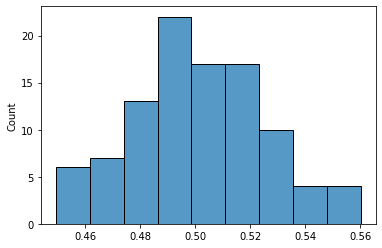

In [106]:
sns.histplot(scores)

,test_f1_macro,test_accuracy
2016-03-31,0.472513,0.509857
2016-06-30,0.315765,0.385000
2016-09-30,0.375707,0.420429
2016-12-31,0.494402,0.546714
2017-03-31,0.358484,0.396333
2017-06-30,0.428835,0.463571
2017-09-30,0.526058,0.569143
2017-12-31,0.592470,0.625571
2018-03-31,0.450287,0.483143
2018-06-30,0.418244,0.463714


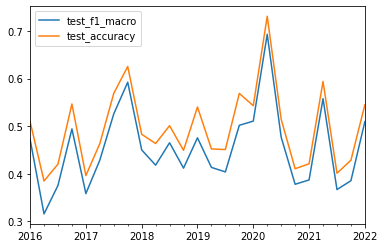

In [182]:
quarter_scores = merged.groupby(pd.Grouper(freq='Q')).apply(lambda x: np.mean(pd.DataFrame([cross_validation_pipe(x[x.columns[:-4]], x.label_adjusted_increase) for _ in range(100)]), axis=0))
quarter_scores = quarter_scores.drop(columns=['fit_time', 'score_time'])
quarter_scores = quarter_scores.drop(quarter_scores.tail(1).index)
quarter_scores.plot()
quarter_scores
#merged.groupby(pd.Grouper(freq='QS')).apply(lambda x: np.mean(x.label_adjusted_increase)).plot()

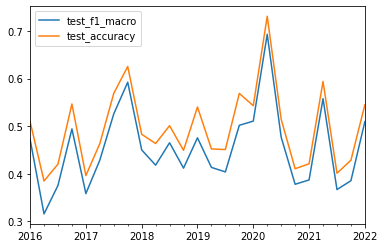

In [191]:
fig = quarter_scores.plot().get_figure()
fig.savefig("test.pdf")

In [185]:
np.mean(quarter_scores.test_accuracy > 0.5)

0.48